# Contact Database Analysis

This project presents an end-to-end data analytics research based on a large-scale dataset exported directly from HubSpot, containing over 70,000 records. The dataset represents real-world CRM data and captures multiple dimensions of customer, company, deal (revenue), and traffic attribution.

## Setting up the environment

Importing required libraries for data loading, inspection and initial cleaning.

In [110]:
import pandas as pd # data manipulation and analysis
import numpy as np # numerical operations
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import warnings # to handle warnings (e.g., deprecation warnings)

Importing dataset:

In [111]:
raw_path = "data/multi-dimensional-contact-segme.csv"

df = pd.read_csv(raw_path) # Inspecting the dataset
df.head() # Displays the first few rows of the dataset
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

,Full Name,Create Date,Email,Industry,Website URL,Country/Region,Annual Revenue,Lifecycle Stage,Original Source,Original Source Drill-Down 1,Deal Stage,Closed amount
0,Darren Lindsay,21/10/2022 11:06,darren@agmchilleddistribution.co.uk,Logistics,agmchilleddistribution.co.uk,United Kingdom,(No value),Opportunity,Paid Search,cold stores uk,(No value),(No value)
1,Grady Broadhurst,18/10/2022 10:58,gradyb@hotmail.co.uk,(No value),(No value),United Kingdom,(No value),Lead,Paid Search,blast freezer uk,(No value),(No value)
2,Graham hall,17/10/2022 14:09,info@hallsofhazlemere.com,(No value),hallsofhazlemere.com,England,(No value),Lead,Paid Search,refrigerated containers,(No value),(No value)
3,Kate Sampson,25/10/2022 15:09,kate@copas.co.uk,Meat,copas.co.uk,(No value),10000000,Lead,Direct Traffic,www.crscoldstorage.co.uk/refrigeration/refrige...,(No value),(No value)
4,martin rowland,26/10/2022 09:18,martinrowland30@gmail.com,Hospitality,(No value),United Kingdom,(No value),Customer,Paid Search,cold stores uk,Closed Won (Salesforce - Opportunity),9320


## Managing missing values

In [112]:
# Inspecting missing values

df.info() # Shows column names, non-null counts, and inferred data types.
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html

df.isna().sum() # Counts true missing values (NaN) in each column.
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

np.sum(df == "(No value)") # Counts custom missing value indicators in each column.
# Reference: https://numpy.org/doc/stable/reference/generated/numpy.sum.html

np.sum(df == "(No value)", axis=0) # Counts custom missing value indicators.
# Using `axis=0 to sum over rows for each column.
# Reference: https://numpy.org/doc/stable/reference/generated/numpy.sum.html

warnings.filterwarnings("ignore") # Suppresses warnings for cleaner output
# Reference: https://docs.python.org/3/library/warnings.html#warnings.filterwarnings


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72198 entries, 0 to 72197
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Full Name                     72198 non-null  object
 1   Create Date                   72198 non-null  object
 2   Email                         72198 non-null  object
 3   Industry                      72198 non-null  object
 4   Website URL                   72198 non-null  object
 5   Country/Region                72187 non-null  object
 6   Annual Revenue                72198 non-null  object
 7   Lifecycle Stage               72198 non-null  object
 8   Original Source               72198 non-null  object
 9   Original Source Drill-Down 1  72198 non-null  object
 10  Deal Stage                    72198 non-null  object
 11  Closed amount                 72198 non-null  object
dtypes: object(12)
memory usage: 6.6+ MB


Before cleaning the dataset, it is necessary to understand where the missing or incomplete values occur.<br>
HubSpot exports often contain two types of missing data:
- True missing values (NaN), recognised automatically by pandas.
- Placeholder strings such as "(No value)", which are not treated as missing values by pandas but still represent incomplete data.<br>
This step profiles both kinds. No rows will be removed; instead, missing fields will be handled in a way that preserves as much useful information as possible.

NumPy is used for the boolean-array summation because it provides a clear and efficient way to count True/False values across the dataset.

*Handling Warnings:*<br>
Python libraries such as pandas and NumPy often generate non-critical warnings during data analysis (e.g., FutureWarning or DeprecationWarning). These warnings do not indicate errors and do not affect the correctness of the analysis, but they can clutter the notebook output and make results harder to interpret. The warnings module is used here to suppress non-essential warnings, improving readability while still allowing real errors to appear.

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html
- https://numpy.org/doc/stable/reference/generated/numpy.sum.html
- https://numpy.org/doc/stable/reference/generated/numpy.sum.html
- https://stackoverflow.com/questions/27261015/boolean-in-a-numpy-sum
- https://numpy.org/devdocs/reference/generated/numpy.sum.html
- https://docs.python.org/3/library/warnings.html#warnings.filterwarnings
- https://docs.python.org/3/library/warnings.html
- https://stackoverflow.com/questions/3920502/how-to-suppress-a-third-party-warning-using-warnings-filterwarnings
- https://www.geeksforgeeks.org/python/how-to-disable-python-warnings/

## Data Cleaning - part 1

Before cleaning the dataset, it is essential to quantify how many "(No value)" placeholders appear in each column.<br>
HubSpot uses "(No value)" to represent missing or unavailable data across every field, not just numeric columns.

Pandas does not recognise "(No value)" as a missing value (`NaN`), so knowing the frequency of this placeholder is necessary to:
- understand how complete data is
- prepare an appropriate cleaning strategy
- prevent errors during later type conversions (numeric or datetime)

In [113]:
# Counting how many times the placeholder "(No value)" appears in each column.
(df == "(No value)").sum()
# This expression uses boolean comparison to create a True/False dataframe.
# True indicates a cell that exactly matches "(No value)".
# The .sum() operation counts True values per column.


Full Name                       72192
Create Date                         0
Email                              11
Industry                        18103
Website URL                     22306
Country/Region                   9913
Annual Revenue                  35597
Lifecycle Stage                  7214
Original Source                     0
Original Source Drill-Down 1        0
Deal Stage                      68058
Closed amount                   68060
dtype: int64

`df == "(No value)"` compares every cell in the dataframe against the string "(No value)".<br>
`.sum()`here pandas treats True as 1 and False as 0.

The output gives a better insight:<br>
- A lot of missing data which varies between columns.
- Numeric fields (Annual revenue and Closed amount) require different approach
- Fields such as Email, Original source and Original source drill-down 1 are complete or almost complete and give us very reliable insight.

**📚 References:**<br>
- https://www.geeksforgeeks.org/pandas/boolean-indexing-in-pandas/
- https://pandas.pydata.org/docs/user_guide/indexing.html#boolean-indexing
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html
- https://www.w3schools.com/python/pandas/ref_df_sum.asp#:~:text=The%20sum()%20method%20adds,the%20sum%20of%20each%20row.
- https://stackoverflow.com/questions/38733477/whats-the-best-way-to-sum-all-values-in-a-pandas-dataframe
- https://towardsdatascience.com/3-approaches-to-find-missing-values-ff656eba6902/

## Data Cleaning - part 2 (per column)

### Approach:

The HubSpot dataset is inconsistent so each column needs to be addressed individually.

1. **Full Name** - this column contains "(No value)" in almost all rows. "(No value)" will be replaced with `NaN`. Also, this column is too incomplete for further analysis.

2. **Create Date** - no missing values in this column, which is a good thing. This column needs to be converted to datetime for time-based analysis.

3. **Email** - contains only 11 "(No Value") spots. Because the Website URL column contains over 22,000 missing entries, the Email column becomes the most reliable source for extracting domain-level company information (for example: `ian.bartlett@aldi.co.uk` → `aldi.co.uk`). <br>
Also, corporate emails (such as `@dornangroup.com`) indicate larger companies, while personal emails (`@gmail.com`, etc.) represent sole traders and smaller businesses. This will help for further segmentation.

4. **Industry** - has 18,103 missing values but still enough data for segmentation.

5. **Website URL** - 22,306 missing values, but this can be supplemented as explained in the Email section.

6. **Country/Region** - 9,913 missing values but still solid amount of data. The Email field becomes the most reliable secondary source for finding geographic information (for example: co.uk → United Kindom, .ie → Ireland and so on).

7. **Annual Revenue** - even though this field contains 35,597 missing entries, the values that are present still provide a lot of value. Many rows include very large revenue figures (e.g., £10 million, £250 million, etc.), which indicate that a subset of the contacts represents high-value corporate entities. Existing values need to be converted from string to numeric.

8. **Lifecycle stage** - 7,214 missing values, still good for segmentation.

9. **Original Source** - no missing values, which is great.

10. **Original Source Drill-Down 1** - this column shows further drill down of the Original Source (for example: original source is offline, but drill-down shows it is a Salesforce import OR original source shows Paid search but the Drill down column shows the exact keywords). This column enhances categories from the Original Source.<br>
Analysis options:
- Attribution analysis - identifying which keywords, campaigns, or Salesforce import types generate the most contacts or conversions.
- Keyword-level segmentation - extracting search terms to detect user intent (where applicable).
- CRM integration insights - shows how many contacts and/or won deals come from Salesforce database import.
- Further drill-down possible based on the above findings.

11. **Deal Stage** - contains 68,058 non-values, which is expected because most contacts in a CRM system never enter a sales pipeline. However, the remaining values (such as 'Closed Won (Salesforce - Opportunity)' or 'Quote Given (Salesforce - Opportunity)') can provide useful information for analysis and sales funnel insights.

12. **Closed amount** - requires conversion of numeric values to be used in further analysis.

### Replacement of "(No value)":

In [114]:
df = df.replace("(No value)", np.nan) # Replacing "(No value)" with actual NaN for consistency in missing data representation.
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html

The above code replaces "(No value)" across the dataset.

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
- https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
- https://www.geeksforgeeks.org/data-analysis/working-with-missing-data-in-pandas/

### Conversion from string to numeric:

In [115]:
# Annual Revenue: converting to numeric, coercing errors to NaN

df['Annual Revenue'] = pd.to_numeric(df['Annual Revenue'], errors='coerce')
# pd.to_numeric converts string values into numeric dtype.
# errors='coerce' ensures that any invalid or non-numeric values are converted to NaN.

# Closed amount: same as above
df['Closed amount'] = pd.to_numeric(df['Closed amount'], errors='coerce')

In the above step, the 'Annual Revenue' and 'Closed amount' colums were converted from text (string) format into numerical values. Because both columns contain a mix of numeric strings and missing values, `errors='coerce'` was used → this instructs pandas to convert strings into real numbers and to replace missing values with NaN.

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
- https://www.geeksforgeeks.org/python/python-pandas-to_numeric-method/
- https://stackoverflow.com/questions/57286501/why-pd-to-numeric-errors-is-equivalent-to-errors-coerce

### Conversion to datetime:

In [116]:
# Create Date: converting to datetime, coercing errors to NaT

df['Create Date'] = pd.to_datetime(df['Create Date'], errors='coerce')
# pd.to_datetime converts string-formatted dates into pandas datetime objects.
# errors='coerce' ensures invalid or unrecognized date strings become NaT instead of raising an error.

In the above step, the Create Date column was converted from text into a proper datetime format.<br>
Converting the column with `pd.to_datetime()` ensures that the dates can be used for time-based analysis such as filtering, grouping by month or year, etc. Using `errors='coerce'` ensures that any invalid date values are converted to `NaT` to prevent errors.

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
- https://www.geeksforgeeks.org/pandas/python-pandas-to_datetime/
- https://stackoverflow.com/questions/36692861/avoiding-error-from-pd-to-datetime-in-pandas

### Email formatting:

In [117]:
# Email: standardising formatting by trimming whitespace and converting to lowercase

df['Email'] = df['Email'].str.strip()
# .str.strip() removes leading and trailing whitespace characters from each string in the column.

df['Email'] = df['Email'].str.lower()
# .str.lower() converts all characters in the string to lowercase
# keeps consistency for domain extraction and comparison

df['Email'].head(10)
# Displays the first 10 entries of the cleaned 'Email' column


0    darren@agmchilleddistribution.co.uk
1                   gradyb@hotmail.co.uk
2              info@hallsofhazlemere.com
3                       kate@copas.co.uk
4              martinrowland30@gmail.com
5                   simon@cakesmiths.com
6              justin@ravenexpress.co.uk
7              adam.thomas@greencore.com
8              allstarprov@optonline.net
9          gill.lyth@stuartandswan.co.uk
Name: Email, dtype: object

Before extracting information from the Email column, the raw email strings must be cleaned and standardised. This involves converting all email addresses to lowercase and removing any leading or trailing whitespace. These corrections ensure consistent handling of domains, accurate classification of email types, and reliable matching during segmentation.

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html
- https://www.w3schools.com/python/ref_string_strip.asp
- https://www.geeksforgeeks.org/pandas/python-pandas-series-str-strip-lstrip-and-rstrip/
- https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
- https://www.w3schools.com/python/ref_string_lower.asp
- https://www.geeksforgeeks.org/python/python-string-lower/
- https://pandas.pydata.org/docs/reference/api/pandas.Series.str.lower.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

### Extracting email domains:

In [118]:
# Extracting the domain part of each email address:
df['Email Domain'] = df['Email'].str.split('@').str[-1]
# .str.split('@') splits each email string into two parts: local name and domain.
# .str[-1] selects the last part (domain) after the split.

# Inspecting the first 10 extracted domains to check the formatting:
df[['Email', 'Email Domain']].head(10)
# .head(10) displays the first 10 rows for verification.

,Email,Email Domain
0,darren@agmchilleddistribution.co.uk,agmchilleddistribution.co.uk
1,gradyb@hotmail.co.uk,hotmail.co.uk
2,info@hallsofhazlemere.com,hallsofhazlemere.com
3,kate@copas.co.uk,copas.co.uk
4,martinrowland30@gmail.com,gmail.com
5,simon@cakesmiths.com,cakesmiths.com
6,justin@ravenexpress.co.uk,ravenexpress.co.uk
7,adam.thomas@greencore.com,greencore.com
8,allstarprov@optonline.net,optonline.net
9,gill.lyth@stuartandswan.co.uk,stuartandswan.co.uk


After standardising the email formatting, the next step is to extract the domain portion of each email address. The domain identifies the organisation or email provider used by the contact. This information is essential for several analysis options, including:
- distinguishing corporate vs personal email addresses
- inferring company information where website URLs are missing
- identifying geographic indicators from top-level domains (example: .co.uk, .ie, .de)
- grouping contacts by organisation for segmentation purposes

To extract the domain, each email string is split at the "@" character and the final element of the resulting list is selected. This method works for all valid email addresses and preserves missing values (NaN).

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html
- https://stackoverflow.com/questions/53044548/how-to-extract-domain-from-email-address-with-pandas
- https://www.geeksforgeeks.org/python/split-a-column-in-pandas-dataframe-and-get-part-of-it/
- https://www.geeksforgeeks.org/pandas/python-pandas-split-strings-into-two-list-columns-using-str-split/
- https://medium.com/@amit25173/understanding-pandas-str-split-with-simple-examples-0bd7d12f4b4e

### ...and exporting them:

In [119]:
unique_domains = df['Email Domain'].dropna().unique()
# .dropna() removes missing values.
# .unique() returns the set of unique domain names.

domain_df = pd.DataFrame(unique_domains, columns=['Email Domain'])
# Creates a new DataFrame to make exporting cleaner.

domain_df.to_csv("data/cleaned/email_domains.csv", index=False)
# Exports the list of domains to a new CSV file.

Exporting a list of all unique email domains is a convenient way to manually inspect the variety of domains present in the dataset. It can help with:<br>
- identifying personal email providers
- reviewing corporate domains
- checking keyword-based industry inference

**📚 References:**<br>
- https://realpython.com/how-to-drop-null-values-in-pandas/
- https://pandas.pydata.org/docs/reference/api/pandas.unique.html
- https://www.w3schools.com/python/pandas/ref_df_dropna.asp
- https://www.geeksforgeeks.org/python/python-pandas-dataframe-dropna/
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html

### Adding missing country from UK & IE domains (target markets):

In [120]:
# For missing Country/Region values, checking if the email domain ends with .co.uk or .uk or .ie.
# .str.endswith() checks if a string column ends with a specific substring.

df.loc[
    df['Country/Region'].isna() & df['Email Domain'].str.endswith('.co.uk', na=False),
    'Country/Region'
] = 'United Kingdom'

df.loc[
    df['Country/Region'].isna() & df['Email Domain'].str.endswith('.uk', na=False),
    'Country/Region'
] = 'United Kingdom'

df.loc[
    df['Country/Region'].isna() & df['Email Domain'].str.endswith('.ie', na=False),
    'Country/Region'
] = 'Ireland'

# UK and Ireland are target markets for this dataset, so inference is limited to these domains only.

The Country/Region column contains many missing values. Because our target markets are the UK and Ireland, we can partially improve this field by checking whether an email domain ends with a country-specific domain (such as .ie or co.uk).

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.Series.str.endswith.html
- https://stackoverflow.com/questions/67843895/python-loc-confusion-help-using-str-endswith
- https://stackoverflow.com/questions/78382398/how-to-add-a-column-on-a-pandas-dataframe-that-is-based-on-the-continent-a-count
- https://www.geeksforgeeks.org/python/python-pandas-dataframe-loc/
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html
- https://www.geeksforgeeks.org/python/python-pandas-dataframe-isna/
- https://www.ionos.com/digitalguide/websites/web-development/python-pandas-dataframe-isna/
- https://python.plainenglish.io/how-to-prevent-pandas-from-interpreting-na-string-as-nan-00202f000a7d
- https://stackoverflow.com/questions/28311655/ignoring-nans-with-str-contains

### Industry vs Total Annual Revenue by Lifecycle Stage (data prep):

Before creating the chart, the dataset must be prepared so that only valid and complete data points are used. The goal is to visualise how total annual revenue compares across industries and across lifecycle stages, which requires all three fields (Industry, Annual Revenue, Lifecycle Stage) to be present.

In [121]:
# Creating a subset of the data for visualization by dropping rows with missing values in key columns.
df_chart = df.dropna(subset=['Industry', 'Annual Revenue', 'Lifecycle Stage'])

The `.dropna()` function removes rows that are missing information in the required columns.
This ensures the chart includes only contacts that contain all three values, preventing errors and misleading results.

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
- https://www.w3schools.com/python/pandas/ref_df_dropna.asp
- https://www.geeksforgeeks.org/python/python-pandas-dataframe-dropna/

In [122]:
# Grouping the data by 'Industry' and 'Lifecycle Stage', summing 'Annual Revenue' for each group.
grouped_rev = df_chart.groupby(['Industry', 'Lifecycle Stage'])['Annual Revenue'].sum().reset_index()

This step groups the data by Industry and Lifecycle Stage, and then calculates the total Annual Revenue for each group using `.sum()`. This is necessary because multiple contacts may belong to the same industry and lifecycle stage.
- `.groupby()` allows grouping by categorical fields
- `.sum()` calculates total revenue
- `.reset_index()` converts the grouped object back into a DataFrame for plotting

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
- https://www.geeksforgeeks.org/pandas/python-pandas-dataframe-groupby/
- https://www.w3schools.com/python/pandas/ref_df_groupby.asp
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html
- https://www.w3schools.com/python/pandas/ref_df_reset_index.asp
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
- https://www.geeksforgeeks.org/pandas/python-pandas-dataframe-reset_index/
- https://www.datacamp.com/tutorial/pandas-reset-index-tutorial

In [123]:
# Selecting the top 10 industries by total annual revenue for focused visualization
top_industries = grouped_rev.groupby('Industry')['Annual Revenue'].sum().nlargest(10).index

There are many industries in the dataset. Plotting all of them would make the chart unreadable.<br>
This step identifies the Top 10 industries with the highest total revenue, making the visualisation focused and easier to read.
- `.groupby('Industry')['Annual Revenue'].sum()` calculates total revenue per industry
- `.nlargest(10)` selects the 10 highest revenue values
- `.index` extracts the industry names

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.Series.nlargest.html
- https://stackoverflow.com/questions/71788699/how-to-use-groupby-in-pandas-to-sum-total-revenue-of-a-customer
- https://www.geeksforgeeks.org/python/pandas-groupby-and-sum/
- https://www.w3schools.com/python/pandas/ref_df_nlargest.asp
- https://www.w3schools.com/python/ref_list_index.asp
- https://www.geeksforgeeks.org/python/python-list-index/

In [124]:
# Filtering the grouped data to include only the top industries.
grouped_top = grouped_rev[grouped_rev['Industry'].isin(top_industries)]

`.isin()` filters the grouped data to keep only the rows where Industry matches one of the top industries identified earlier.

**📚 References:**<br>
- https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html
- https://www.geeksforgeeks.org/python/python-pandas-dataframe-isin/
- https://www.w3schools.com/python/pandas/ref_df_isin.asp

### Plot no.1 - Industry vs Total Annual Revenue by Lifecycle Stage:

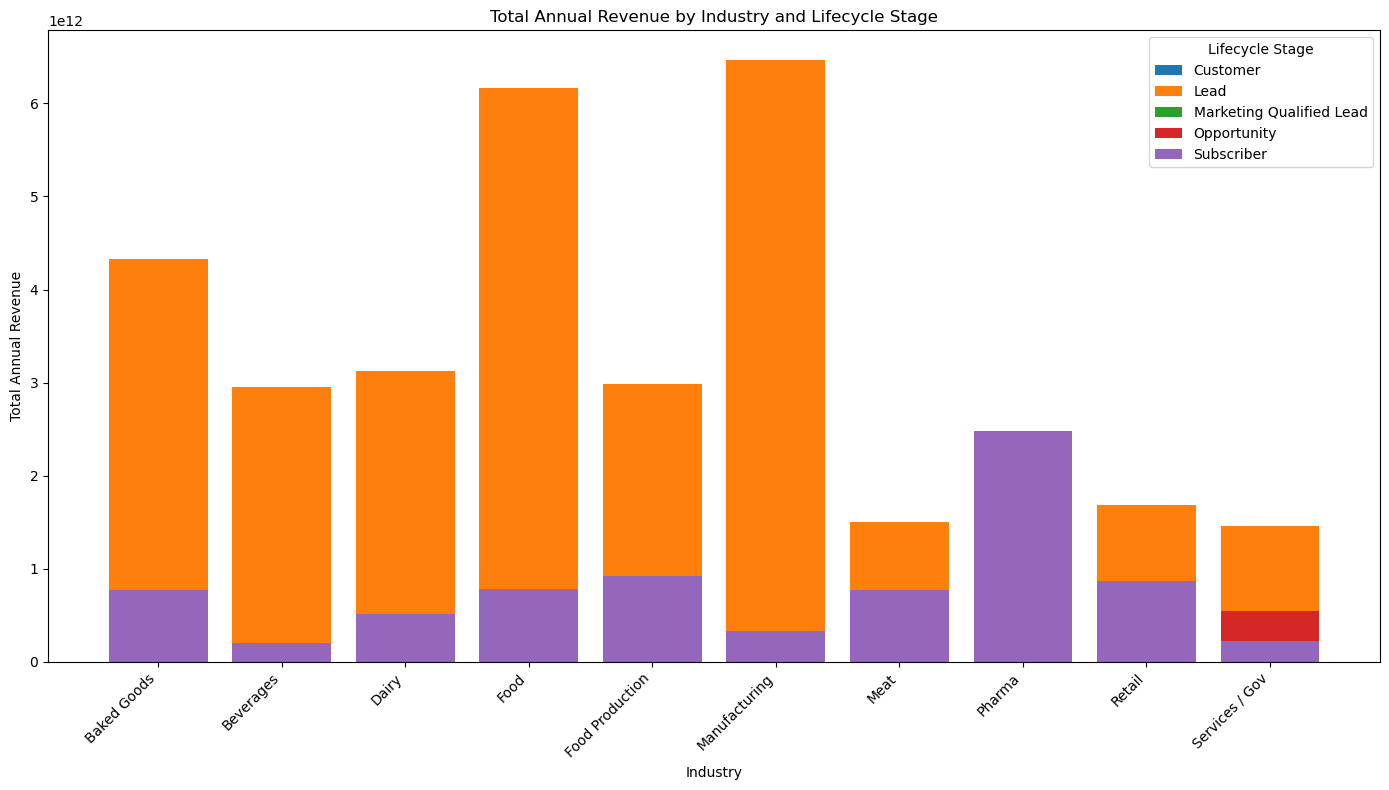

In [ ]:
plt.figure(figsize=(14, 8)) # Increases the figure size for better readability
# 📚 Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

# This loop creates a bar for each combination of industry and lifecycle stage:
for stage in grouped_top['Lifecycle Stage'].unique(): # Retrieves the list of all lifecycle stages in the data
    stage_data = grouped_top[grouped_top['Lifecycle Stage'] == stage] # Filters data for the current lifecycle stage
    plt.bar(stage_data['Industry'], stage_data['Annual Revenue'], label=stage) # Plots bars for each lifecycle stage
# Adding a label= allows the legend to distinguish stages
# 📚 References: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unique.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
# https://www.geeksforgeeks.org/pandas/bar-plot-in-matplotlib/

# Industry names can be long, so rotating them prevents overlap:
plt.xticks(rotation=45, ha='right')
# 📚 Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html

# Adding axis labels, title and legend:
plt.xlabel('Industry')
plt.ylabel('Total Annual Revenue')
plt.title('Total Annual Revenue by Industry and Lifecycle Stage')
plt.legend(title='Lifecycle Stage')
plt.tight_layout() # Adjusts layout to prevent clipping 
# 📚 References: https://www.w3schools.com/python/matplotlib_labels.asp
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/index.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylabel.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlabel.html
# https://www.geeksforgeeks.org/python/matplotlib-pyplot-title-in-python/
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html

# Saving plot to the plots folder:
plt.savefig("plots/industry_revenue_lifecycle.png", dpi=300, bbox_inches='tight')
# .savefig() saves the current figure to a file.
# "plots/..." ensures the plot is saved inside the project's plots folder.
# dpi=300 increases resolution (suitable for reports).
# bbox_inches='tight' trims extra whitespace.
# Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

plt.show() # Displays the final bar chart
# 📚 Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html



The plot above shows the total annual revenue generated by companies across the Top 10 industries, further broken down by Lifecycle Stage. Each industry is represented on the x-axis, and the height of each coloured bar reflects the combined annual revenue for that lifecycle stage within that industry.

This reveals several interesting patterns:<br>
- Manufacturing, Food, and Baked Goods show the highest overall revenue totals. These industries appear to include a greater number of large-revenue companies.
- Most of the revenue across industries comes from contacts in the “Lead” lifecycle stage. This indicates that many high-revenue companies are still early in the sales funnel rather than being active customers.
- The “Subscriber” stage also appears noticeably in some industries, such as Pharma and Retail. That suggests these segments contain many contacts who have engaged but not yet progressed into qualified leads.
- Very few industries show significant revenue under “Opportunity” or “Customer” stages, implying that a relatively small proportion of high-value companies have advanced through the sales pipeline.

The results suggest that the company already has access to a good database of high-value organisations, but improvements in lead nurturing, lifecycle progression, and industry-specific sales strategies would provide additional commercial growth.
